# Training Notebook

In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import cv2
import os
import pandas as pd
import numpy as np

In [95]:
# Load training data
X_train_full = np.load('datasets/train_data.npy')
t_train_full = np.load('datasets/train_labels.npy')
print(X_train_full.shape, t_train_full.shape)

(51975, 48, 48, 3) (51975,)


In [ ]:
#IGNORE 
temp = []

for i in range(X_train_full.shape[0]):
    img = X_train_full[i,:].reshape(48,48, 3)
    res = cv2.resize(img, dsize=(244,244))
    temp.append(res)

In [8]:
#IGNORE
X_train_full = np.array(temp).reshape(-1, 244, 244, 3)
temp = []

TypeError: unsupported operand type(s) for +: 'int' and 'str'

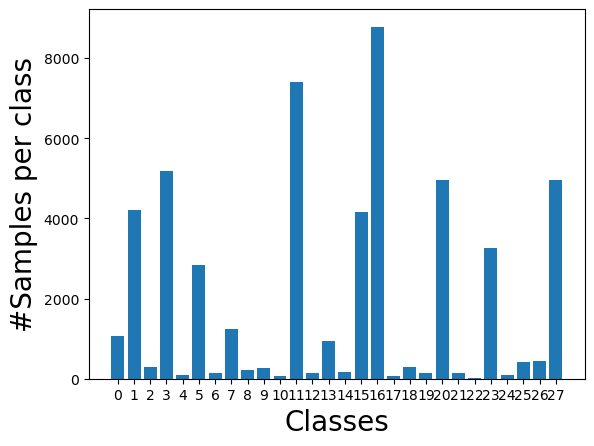

In [96]:
vals, counts = np.unique(t_train_full, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(28), range(28))
plt.xlabel('Classes',size=20)
plt.ylabel('#Samples per class', size=20)
plt.title('Training Data (Total = '+str(X_train_full.shape[1]+' samples)', size=15));

### Preprocess data for keras


In [97]:
X_train_full = tf.keras.applications.mobilenet_v2.preprocess_input(X_train_full)
#t_train_full = tf.keras.applications.mobilenet_v2.preprocess_input(t_train_full)
print(X_train_full.shape, t_train_full.shape)

(51975, 48, 48, 3) (51975,)


### Split data to training and validation sets

In [98]:
X_train, X_val, t_train, t_val = train_test_split(X_train_full, t_train_full,
                                                 test_size=0.2,
                                                 stratify=t_train_full,
                                                 random_state=0,
                                                 shuffle=True)

X_train.shape, X_val.shape, t_train.shape, t_val.shape

((41580, 48, 48, 3), (10395, 48, 48, 3), (41580,), (10395,))

### Create model

#### Model 1 MobileNetV2, activation function=Nadam, weights=imagenet, frozen layers, pooling

In [68]:
img_shape = (48, 48, 3)
base_model = tf.keras.applications.MobileNetV2(input_tensor=keras.layers.Input(shape=(48, 48,3)),
                                          include_top=False,
                                          weights='imagenet')
base_model.trainable = False

model = keras.Sequential([layers.Flatten(input_shape=[48,48,3]),
                         layers.Dense(48, activation='relu'),
                         layers.Dense(30, activation='relu'),
                         layers.Dense(28, activation='softmax')])
base_learning_rate = 0.0001

"categorical_crossentropy"
model.compile(optimizer=tf.keras.optimizers.Nadam(),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(X_train, t_train, epochs=25,
             validation_data=(X_val, t_val),
             callbacks=[keras.callbacks.EarlyStopping(patience=10)])


Epoch 1/25
1300/1300 [==============================] - 7s 5ms/step - loss: 2.2735 - accuracy: 0.2702 - val_loss: 2.1058 - val_accuracy: 0.3006
Epoch 2/25
1300/1300 [==============================] - 6s 4ms/step - loss: 2.0251 - accuracy: 0.3190 - val_loss: 2.0198 - val_accuracy: 0.3177
Epoch 3/25
1300/1300 [==============================] - 6s 4ms/step - loss: 1.9491 - accuracy: 0.3372 - val_loss: 2.0004 - val_accuracy: 0.3238
Epoch 4/25
1300/1300 [==============================] - 6s 5ms/step - loss: 1.9042 - accuracy: 0.3538 - val_loss: 2.0013 - val_accuracy: 0.3321
Epoch 5/25
1300/1300 [==============================] - 6s 5ms/step - loss: 1.8690 - accuracy: 0.3609 - val_loss: 1.9822 - val_accuracy: 0.3354
Epoch 6/25
1300/1300 [==============================] - 6s 5ms/step - loss: 1.8402 - accuracy: 0.3713 - val_loss: 1.9878 - val_accuracy: 0.3436
Epoch 7/25
1300/1300 [==============================] - 8s 6ms/step - loss: 1.8097 - accuracy: 0.3810 - val_loss: 1.9920 - val_accuracy:

### Model 2, MobileNetV2, frozen layers, RMSprop optimizer, pooling

In [70]:
img_shape = (48, 48, 3)
base_model = tf.keras.applications.MobileNetV2(input_tensor=keras.layers.Input(shape=(48, 48,3)),
                                          include_top=False,
                                          weights='imagenet')
base_model.trainable = False
global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(28)
model = tf.keras.Sequential([base_model,
                              global_average_layer,
                              prediction_layer])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])


history = model.fit(X_train, t_train, epochs=25,
             validation_data=(X_val, t_val),
             callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/25
1300/1300 [==============================] - 157s 119ms/step - loss: 5.2260 - accuracy: 0.1355 - val_loss: 3.4290 - val_accuracy: 0.0876
Epoch 2/25
1300/1300 [==============================] - 150s 115ms/step - loss: 3.3923 - accuracy: 0.0858 - val_loss: 3.3794 - val_accuracy: 0.0824
Epoch 3/25
1300/1300 [==============================] - 145s 111ms/step - loss: 3.3603 - accuracy: 0.0794 - val_loss: 3.3656 - val_accuracy: 0.0791
Epoch 4/25
1300/1300 [==============================] - 146s 112ms/step - loss: 3.3474 - accuracy: 0.0796 - val_loss: 3.3606 - val_accuracy: 0.0794
Epoch 5/25
1300/1300 [==============================] - 145s 112ms/step - loss: 3.3425 - accuracy: 0.0790 - val_loss: 3.3582 - val_accuracy: 0.0795
Epoch 6/25
1300/1300 [==============================] - 147s 113ms/step - loss: 3.3389 - accuracy: 0.0790 - val_loss: 3.3558 - val_accuracy: 0.0797
Epoch 7/25
1300/1300 [==============================] - 148s 114ms/step - loss: 3.3372 - accuracy: 0.0793 - val_

### Model 3 CNN using sequential API, adam optimizer

In [71]:
# 
base_model2 = tf.keras.models.Sequential()

base_model2.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(48,48,3)))
base_model2.add(layers.BatchNormalization())
base_model2.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
base_model2.add(layers.BatchNormalization())
base_model2.add(layers.MaxPool2D(2,2))
base_model2.add(layers.Dropout(0.3))
base_model2.add(layers.Conv2D(128, kernel_size=(3,3), padding='same',activation='relu', kernel_regularizer=keras.regularizers.l2()))
base_model2.add(layers.BatchNormalization())
base_model2.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2()))
base_model2.add(layers.BatchNormalization())
base_model2.add(layers.MaxPool2D(2,2))
base_model2.add(layers.Dropout(0.4))
base_model2.add(layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2()))
base_model2.add(layers.BatchNormalization())
base_model2.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2()))
base_model2.add(layers.BatchNormalization())
base_model2.add(layers.MaxPool2D(2,2))
base_model2.add(layers.Dropout(0.5))
base_model2.add(layers.Conv2D(512, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2()))
base_model2.add(layers.BatchNormalization())
base_model2.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.l2()))
base_model2.add(layers.BatchNormalization())
base_model2.add(layers.MaxPool2D(2,2))
base_model2.add(layers.Dropout(0.3))

base_model2.add(layers.Flatten())
base_model2.add(layers.Dense(1024, activation='relu'))
base_model2.add(layers.Dropout(0.4))
base_model2.add(layers.Dense(256, activation='relu'))
base_model2.add(layers.Dense(28, activation='softmax'))

In [72]:
base_model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss="sparse_categorical_crossentropy",
                   metrics=['accuracy'])
base_model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_32 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                     

In [73]:
history = base_model2.fit(X_train, t_train, epochs=25,
                         validation_data=(X_val, t_val),
                         callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/25
1300/1300 [==============================] - 1907s 1s/step - loss: 10.7606 - accuracy: 0.2458 - val_loss: 9.1096 - val_accuracy: 0.2697
Epoch 2/25
1300/1300 [==============================] - 1838s 1s/step - loss: 7.3813 - accuracy: 0.3125 - val_loss: 5.8724 - val_accuracy: 0.3402
Epoch 3/25
1300/1300 [==============================] - 1854s 1s/step - loss: 4.7127 - accuracy: 0.3536 - val_loss: 3.7378 - val_accuracy: 0.3803
Epoch 4/25
1300/1300 [==============================] - 1876s 1s/step - loss: 3.1463 - accuracy: 0.3836 - val_loss: 2.6443 - val_accuracy: 0.4143
Epoch 5/25
1300/1300 [==============================] - 1849s 1s/step - loss: 2.3987 - accuracy: 0.4126 - val_loss: 2.2028 - val_accuracy: 0.4215
Epoch 6/25
1300/1300 [==============================] - 1862s 1s/step - loss: 2.0975 - accuracy: 0.4263 - val_loss: 1.9939 - val_accuracy: 0.4382
Epoch 7/25
1300/1300 [==============================] - 1893s 1s/step - loss: 1.9558 - accuracy: 0.4386 - val_loss: 1.9185 

In [74]:
import joblib
final_model3 = base_model2
joblib.dump(final_model3, 'models/Model3_trained.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_3
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_4
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_5
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_6
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_7
......vars
.........0
.........1
.........2
.........3
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\conv2d_4
......vars
....

['models/Model3_trained.pkl']

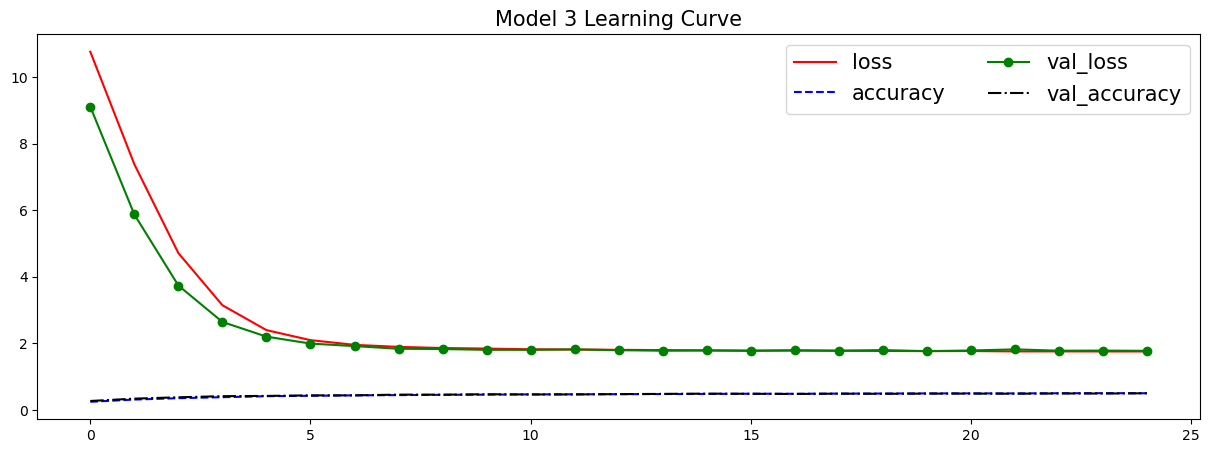

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

key_names = list(history.history.keys())
colors = ['-r', '--b', '-og', '-.k']
plt.figure(figsize=(15,5))
for i in range(len(key_names)):
    plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
plt.legend(fontsize=15, ncol=2)
plt.title('Model 3 Learning Curve', size=15);    

In [76]:
emotions_list = ['Affection', 'Anger', 'Annoyance','Anticipation', 'Aversion',
                'Confidence', 'Disapproval', 'Disconnection', 'Disquietment', 
                'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 
                'Excitement', 'Fatigue', 'Fear', 'Happiness','Pain', 'Peace',
                'Pleasure','Sadness', 'Sensitivity', 'Suffering', 'Surprise',
                'Sympathy', 'Yearning', 'Disgust', 'Neutral']

In [77]:
y_train3 = np.argmax(base_model2.predict(X_train), axis=1)
y_train3.shape

1300/1300 [==============================] - 271s 208ms/step


(41580,)

In [78]:
#around 6 min to predict y_train3

print(classification_report(t_train, y_train3, target_names=emotions_list))

                 precision    recall  f1-score   support

      Affection       0.22      0.01      0.02       850
          Anger       0.68      0.53      0.60      3363
      Annoyance       0.00      0.00      0.00       233
   Anticipation       0.40      0.38      0.39      4147
       Aversion       0.00      0.00      0.00        78
     Confidence       1.00      0.00      0.00      2270
    Disapproval       0.00      0.00      0.00       108
  Disconnection       0.00      0.00      0.00       995
   Disquietment       0.00      0.00      0.00       176
Doubt/Confusion       0.00      0.00      0.00       214
  Embarrassment       0.00      0.00      0.00        58
     Engagement       0.35      0.87      0.50      5923
         Esteem       0.00      0.00      0.00       118
     Excitement       0.00      0.00      0.00       754
        Fatigue       0.00      0.00      0.00       133
           Fear       0.70      0.27      0.39      3323
      Happiness       0.89    

C:\Users\Diana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Diana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Diana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
y_val3 = np.argmax(base_model2.predict(X_val), axis=1) #around 1 min
print(classification_report(t_val, y_val3, target_names=emotions_list))

325/325 [==============================] - 70s 214ms/step
                 precision    recall  f1-score   support

      Affection       0.25      0.00      0.01       213
          Anger       0.58      0.42      0.49       841
      Annoyance       0.00      0.00      0.00        58
   Anticipation       0.37      0.36      0.36      1037
       Aversion       0.00      0.00      0.00        20
     Confidence       0.00      0.00      0.00       568
    Disapproval       0.00      0.00      0.00        27
  Disconnection       0.00      0.00      0.00       249
   Disquietment       0.00      0.00      0.00        44
Doubt/Confusion       0.00      0.00      0.00        53
  Embarrassment       0.00      0.00      0.00        14
     Engagement       0.35      0.85      0.50      1480
         Esteem       0.00      0.00      0.00        29
     Excitement       0.00      0.00      0.00       189
        Fatigue       0.00      0.00      0.00        33
           Fear       0.57   

C:\Users\Diana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Diana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Diana\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
val_train3 = base_model2.evaluate(X_train,t_train)
vali_val3 = base_model2.evaluate(X_val, t_val)

325/325 [==============================] - 69s 213ms/step - loss: 1.7762 - accuracy: 0.5014


### Model 4 unfrozen layers

In [105]:
base_model4 = keras.applications.MobileNetV2(weights='imagenet',
                                            input_shape=(48, 48, 3),
                                            include_top=False)
base_model4.trainable = True

inputs = keras.Input(shape=(48,48,3))
# unfreese all hidden layer
x = base_model4(inputs, training=True)
x_pool = layers.MaxPooling2D()(x)
outputs = layers.Dense(28, activation='softmax', kernel_initializer='he_normal',
                      kernel_regularizer=keras.regularizers.l2(0.01))(x_pool)
model4 = keras.Model(inputs, outputs)
model4.compile(optimizer=keras.optimizers.Adam(learning_rate=0.02),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [106]:
model4.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 1, 1, 1280)       0         
 g2D)                                                            
                                                                 
 dense_36 (Dense)            (None, 1, 1, 28)          35868     
                                                                 
Total params: 2,293,852
Trainable params: 2,259,740
Non-trainable params: 34,112
_________________________________________________________________


In [108]:
history4 = model4.fit(X_train, t_train, epochs=50, batch_size=32,
                     validation_data=(X_val, t_val),
                     callbacks=[keras.callbacks.EarlyStopping(patience=20)])

Epoch 1/50
1300/1300 [==============================] - 479s 368ms/step - loss: 3.6093 - accuracy: 0.1015 - val_loss: 3.1476 - val_accuracy: 0.1110
Epoch 2/50
1300/1300 [==============================] - 444s 341ms/step - loss: 2.9487 - accuracy: 0.1147 - val_loss: 2.8392 - val_accuracy: 0.1160
Epoch 3/50
1300/1300 [==============================] - 444s 342ms/step - loss: 2.7093 - accuracy: 0.1186 - val_loss: 2.6771 - val_accuracy: 0.1215
Epoch 4/50
1300/1300 [==============================] - 443s 341ms/step - loss: 2.5668 - accuracy: 0.1206 - val_loss: 2.5647 - val_accuracy: 0.1215
Epoch 5/50
1300/1300 [==============================] - 444s 341ms/step - loss: 2.4611 - accuracy: 0.1221 - val_loss: 2.4776 - val_accuracy: 0.1224
Epoch 6/50
1300/1300 [==============================] - 443s 341ms/step - loss: 2.3645 - accuracy: 0.1226 - val_loss: 2.4026 - val_accuracy: 0.1229
Epoch 7/50
1300/1300 [==============================] - 442s 340ms/step - loss: 2.2756 - accuracy: 0.1234 - val_

In [109]:
import joblib
final_model4 = model4
joblib.dump(final_model4, 'models/Model4_trained.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\functional
......vars
...layers\functional\layers\add
......vars
...layers\functional\layers\add_1
......vars
...layers\functional\layers\add_2
......vars
...layers\functional\layers\add_3
......vars
...layers\functional\layers\add_4
......vars
...layers\functional\layers\add_5
......vars
...layers\functional\layers\add_6
......vars
...layers\functional\layers\add_7
......vars
...layers\functional\layers\add_8
......vars
...layers\functional\layers\add_9
......vars
...layers\functional\layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\functional\layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\functional\layers\batch_normalization_10
......vars
.........0
.........1
.........2
.........3
...layers\functional\layers\batch_normalization_11
......vars
.........0
.........1
.......

File Name                                             Modified             Size
config.json                                    2023-03-28 08:41:45        89455
metadata.json                                  2023-03-28 08:41:45           64
variables.h5                                   2023-03-28 08:41:46     27786288


['models/Model4_trained.pkl']

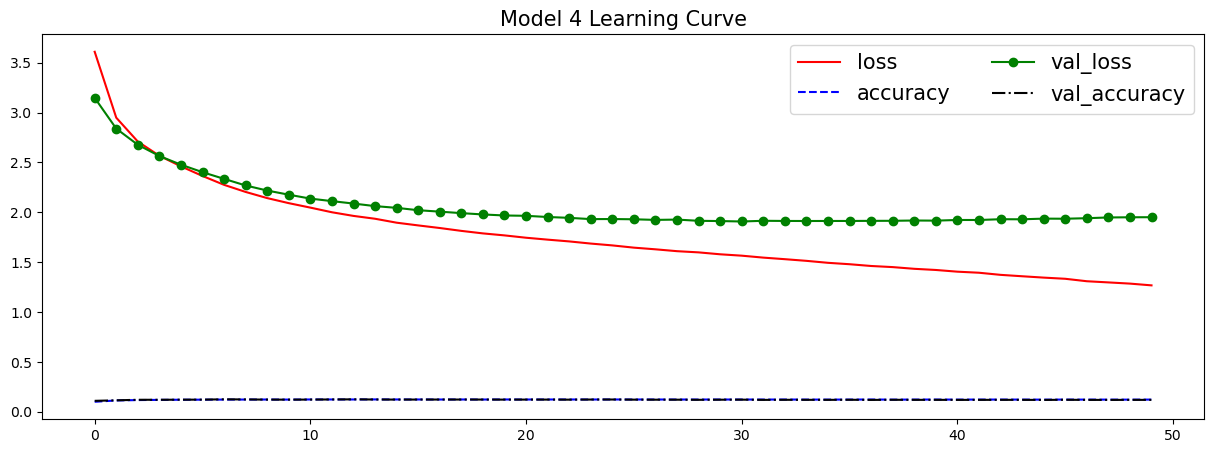

In [110]:
key_names = list(history4.history.keys())
colors = ['-r', '--b', '-og', '-.k']
plt.figure(figsize=(15,5))
for i in range(len(key_names)):
    plt.plot(history4.history[key_names[i]], colors[i], label=key_names[i])
plt.legend(fontsize=15, ncol=2)
plt.title('Model 4 Learning Curve', size=15);    

In [122]:
val_train4 = model4.evaluate(X_train,t_train)
vali_val4 = model4.evaluate(X_val, t_val)

325/325 [==============================] - 63s 192ms/step - loss: 1.9514 - accuracy: 0.1204


### Model 5

In [131]:
base_model5 = tf.keras.applications.MobileNetV2(input_tensor=keras.layers.Input(shape=(48, 48,3)),
                                          include_top=False,
                                          weights='imagenet')
base_model5.trainable = True

base_input5 = base_model2.layers[0].input
base_output5 = base_model2.layers[-2].output


In [132]:
final_output = layers.Dense(1024)(base_output5)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(256)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(28,activation='softmax')(final_output)

In [133]:
model5 = keras.Model(inputs= base_input5, outputs=final_output)

In [134]:
model5.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.03),
                 metrics=["accuracy"])
model5.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32_input (InputLayer  [(None, 48, 48, 3)]      0         
 )                                                               
                                                                 
 conv2d_32 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_32 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                          

In [136]:
history5 = model5.fit(X_train, t_train, epochs=10,
                      steps_per_epoch=len(X_train)//32,
                      validation_steps=len(X_val)//32,
                      batch_size=32,
                     validation_data=(X_val, t_val),
                     callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/10
1299/1299 [==============================] - 2403s 2s/step - loss: 12.8727 - accuracy: 0.1643 - val_loss: 2.5697 - val_accuracy: 0.1690
Epoch 2/10
1299/1299 [==============================] - 2312s 2s/step - loss: 2.5573 - accuracy: 0.1664 - val_loss: 2.5514 - val_accuracy: 0.1690
Epoch 3/10
1299/1299 [==============================] - 2295s 2s/step - loss: 2.5533 - accuracy: 0.1681 - val_loss: 2.5525 - val_accuracy: 0.1690
Epoch 4/10
1299/1299 [==============================] - 2307s 2s/step - loss: 2.5538 - accuracy: 0.1656 - val_loss: 2.5508 - val_accuracy: 0.1690
Epoch 5/10
1299/1299 [==============================] - 2317s 2s/step - loss: 2.5541 - accuracy: 0.1669 - val_loss: 2.5518 - val_accuracy: 0.1690
Epoch 6/10
1299/1299 [==============================] - 2304s 2s/step - loss: 2.5532 - accuracy: 0.1674 - val_loss: 2.5520 - val_accuracy: 0.1690
Epoch 7/10
1299/1299 [==============================] - 2284s 2s/step - loss: 2.5537 - accuracy: 0.1663 - val_loss: 2.5503 